# Imports

In [1]:
from astropy.io import ascii
import photutils ; print("Photutils version:",photutils.__version__)
import numpy as np ; print("Numpy version:",np.__version__)

import matplotlib.pyplot as plt
import seaborn as sns; print("Seaborn version:",sns.__version__)
sns.set()

import tng_api_utils as tau

import os

Photutils version: 0.7.2
Numpy version: 1.18.5
Seaborn version: 0.10.1


# Guide to the data table

Column 01: Snapshot number

Column 02: Subhalo Index

Column 03: RA (degrees)

Column 04: DEC (degrees)

Column 05: RA (proper kpc at true z)

Column 06: DEC (proper kpc at true z)

Column 07: RA (proper kpc at inferred z)

Column 08: DEC (proper kpc at inferred z)

Column 09: True cosmological redshift

Column 10: Inferred redshift (includes peculiar v)

Column 11: Peculiar redshift; Peculiar Velocity / Speed of Light

Column 12: True scale at cosmological z, in kpc/arcsec

Column 13: [Mpc] Comoving X in Observer Coordinates

Column 14: [Mpc] Comoving Y in Observer Coordinates

Column 15: [Mpc] Comoving Z in Observer Coordinates

Column 16: [Mpc] True Angular Diameter Distance to observer

Column 17: [Mpc] Inferred Angular Diameter Distance to observer

Column 18: Snapshot redshift

Column 19: Geometrically appropriate redshift at center of this cylinder

Column 20: Lightcone cylinder number

Column 21: [Msun] Stellar mass within 2X stellar half mass radius

Column 22: [Msun] Total gas mass within 2X stellar half mass radius

Column 23: [Msun] Total mass of this subhalo (excludes children subhalos)

Column 24: [Msun] Total BH mass within 2X stellar half mass radius

Column 25: [Msun] Total baryon mass within 2X stellar half mass radius

Column 26: [Msun/year] SFR within 2X stellar half mass radius

Column 27: [(10^10 Msun/h) / (0.978 Gyr/h)] Total BH accretion rate within subhalo

Column 28: [Mpc] Camera X in Observer Coordinates (Proper X at z; a transverse coordinate)

Column 29: [Mpc] Camera Y in Observer Coordinates (Proper Y at z; a transverse coordinate)

Column 30: [Mpc] Camera Z in Observer Coordinates (Proper Z at z; should be almost exactly Column 16)

Column 31: [AB Mag] Intrinsic stellar g absolute magnitude (BC03)

Column 32: [AB Mag] Intrinsic stellar r absolute magnitude (BC03)

Column 33: [AB Mag] Intrinsic stellar i absolute magnitude (BC03)

Column 34: [AB Mag] Intrinsic stellar z absolute magnitude (BC03)

Column 35: [km/s] Galaxy motion in transverse Camera X direction

Column 36: [km/s] Galaxy motion in transverse Camera Y direction

Column 37: [km/s] Galaxy motion in line-of-sight Camera Z direction ; the Peculiar Velocity

Column 38: [km/s] Cosmological expansion velocity at true z (Column 10 measures Column 37+38)

Column 39: [AB Mag] Apparent total rest-frame g-band magnitude (BC03) 

# Data input

In [2]:
# Read in the data
dash3 = [ascii.read("Lightcone_TNG300-3_mag30_6_5_xyz.txt"), "300-3"]
dash2 = [ascii.read("Lightcone_TNG300-2_mag30_6_5_xyz.txt"), "300-2"]
dash1 = [ascii.read("Lightcone_TNG300-1_mag30_6_5_xyz.txt"), "300-1"]

# Rename the columns to their actually names: w2sr= 'within two times stellar half mass radius'
real_names = ['Snapshot number', 'Subhalo index', 'RA degree', 'DEC degree',
              'RA true z', 'DEC true z', 'RA inferred z', 'DEC inferred z',
              'True z', 'Inferred z', 'Peculiar z', 'True scale',
              'Comoving X', 'Comoving Y', 'Comoving Z',
              'True angular distance', 'Inferred angular distance',
              'Snapshot z', 'Geometric z', 'Lightcone number',
              'Stellar mass w2sr', 'Total gas mass w2sr', 'Total subhalo mass',
              'Total BH mass w2sr', 'Total baryon mass w2sr', 'SFR w2sr',
              'Total BH accretion rate', 'Camera X', 'Camera Y', 'Camera Z',
              'Intrinsic g mag', 'Intrinsic r mag', 'Intrinsic i mag',
              'Intrinsic z mag', 'Galaxy motion X', 'Galaxy motion Y',
              'Galaxy motion Z/Peculiar', 'Cosmological expansion',
              'Apparent total gmag']
i=0
for colname in dash1[0].colnames: # assumes that all the tables are formatted identically
    dash1[0].rename_column(colname, real_names[i])
    dash2[0].rename_column(colname, real_names[i])
    dash3[0].rename_column(colname, real_names[i])
    
    i+=1

# Sanity check graphs

### Redshift histogram

In [5]:
# options: "true", (col09); "snapshot", (col18); "inferred", (col10); "geometric", (col19)
def redshift_hist(redshift_type, data,**kwargs):
    if redshift_type == "true":
        plt.hist(data[0]["True z"],**kwargs)
        plt.title("Data from tng" + data[1])
        plt.xlabel('True redshift')
        plt.ylabel('Count')
        plt.show()
        
    elif redshift_type == "snapshot":
        plt.hist(data[0]["Snapshot z"],**kwargs)
        plt.title("Data from tng" + data[1])
        plt.xlabel('Snapshot redshift')
        plt.ylabel('Count')
        plt.show()
        
    elif redshift_type == "inferred":
        plt.hist(data[0]["Inferred z"],**kwargs)
        plt.title("Data from tng" + data[1])
        plt.xlabel("Inferred redshift")
        plt.ylabel('Count')
        plt.show()
        
    elif redshift_type == "geometric":
        plt.hist(data[0]["Geometric z"],**kwargs)
        plt.title("Data from tng" + data[1])
        plt.xlabel('Geometric redshift')
        plt.ylabel('Count')
        plt.show()
    
    else:
        print ("Mistyped option. Please enter one of the following options: \"true\", (col09); \"snapshot\", (col18); \"inferred\", (col10); \"geometric\", (col19)")
        
    return

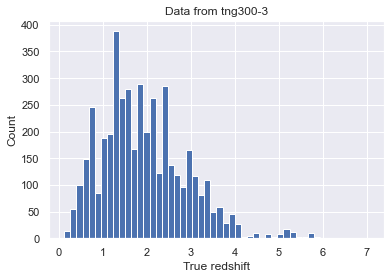

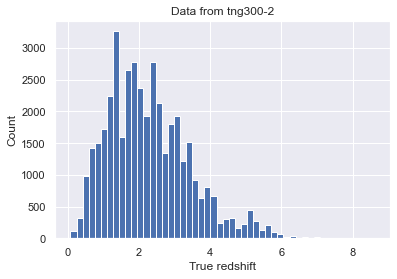

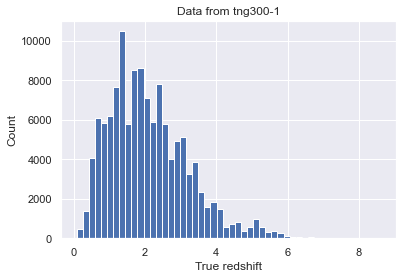

In [7]:
# Example
redshift_hist("true", dash3,bins=50)
redshift_hist("true", dash2,bins=50)
redshift_hist("true", dash1,bins=50)

### Investigate stellar masses

In [73]:
def plot_mass_hist(data,label='TNG300-1',zrange=[0.5,5.0]):
    f=plt.figure(figsize=(15,6))
    ax=f.add_subplot(111)
    zi= np.logical_and( data[0]['True z'] < zrange[1],data[0]['True z'] >= zrange[0])
    res=ax.hist(np.log10(data[0]['Stellar mass w2sr'][zi]),bins=50,range=[9,12])
    x=ax.set_xlabel(label+' $M_*$')
    ax.set_ylim(0,1000)
    ax.set_xlim(9.0,12.0)
    plt.show(f)
    plt.close(f)

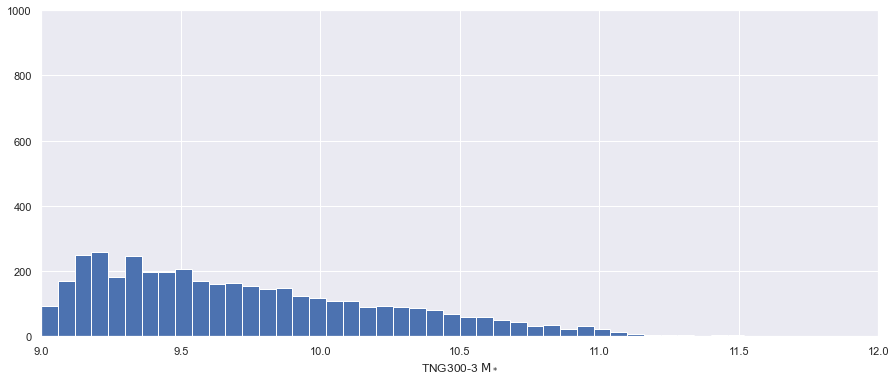

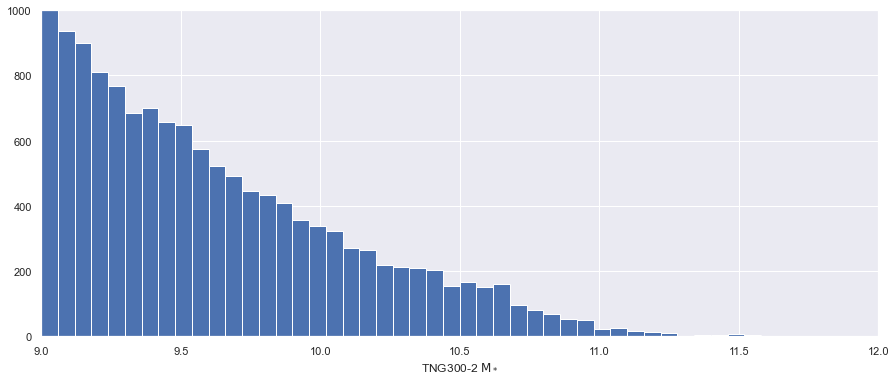

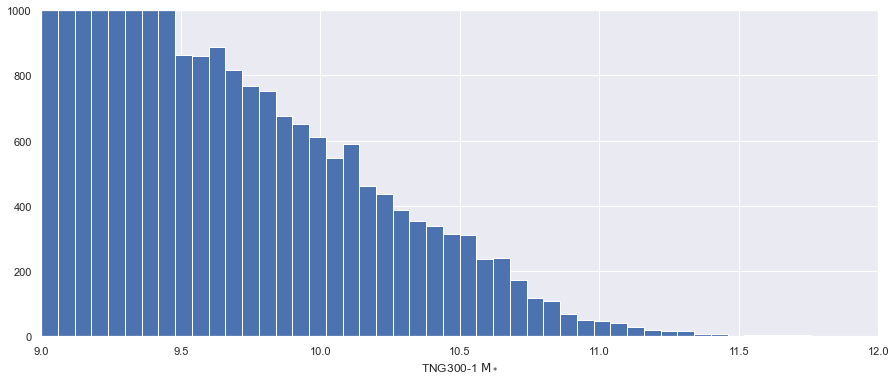

In [74]:
plot_mass_hist(dash3,label='TNG300-3')
plot_mass_hist(dash2,label='TNG300-2')
plot_mass_hist(dash1,label='TNG300-1')

### RA vs. reshift graphs

In [80]:
# Because of all the diffrent kinds of RA and redshift, it's just easier to just pull the data from the array manually
# RA TYPES: 'RA degree', 'RA true z', 'RA inferred z'
# z TYPES: 'True z', 'Inferred z', 'Snapshot z', 'Geometric z'
def ra_vs_redshift(ra_type, z_type, data,mrange=[9.0,12.0],**kwargs):
    plt.figure(figsize=(20,8))
    mi = np.logical_and(np.log10(data[0]['Stellar mass w2sr'])>=mrange[0],np.log10(data[0]['Stellar mass w2sr'])<mrange[1])
    sns.scatterplot(data[0][z_type][mi], data[0][ra_type][mi],**kwargs)
    plt.xlabel(z_type)
    plt.ylabel(ra_type)
    plt.xlim(3.0,5.0)
    plt.title("Data from tng" + data[1])
    plt.show()
    
    return

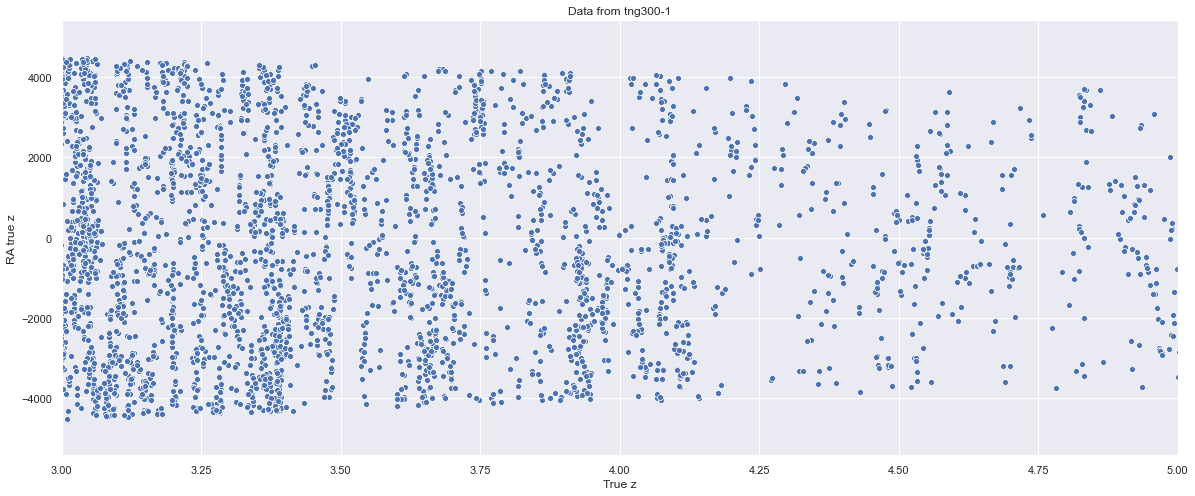

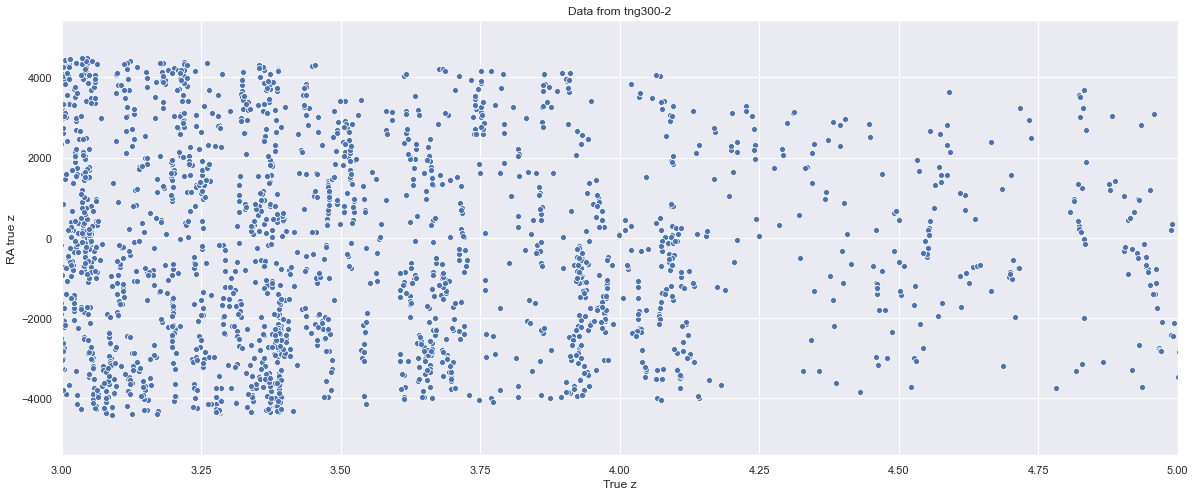

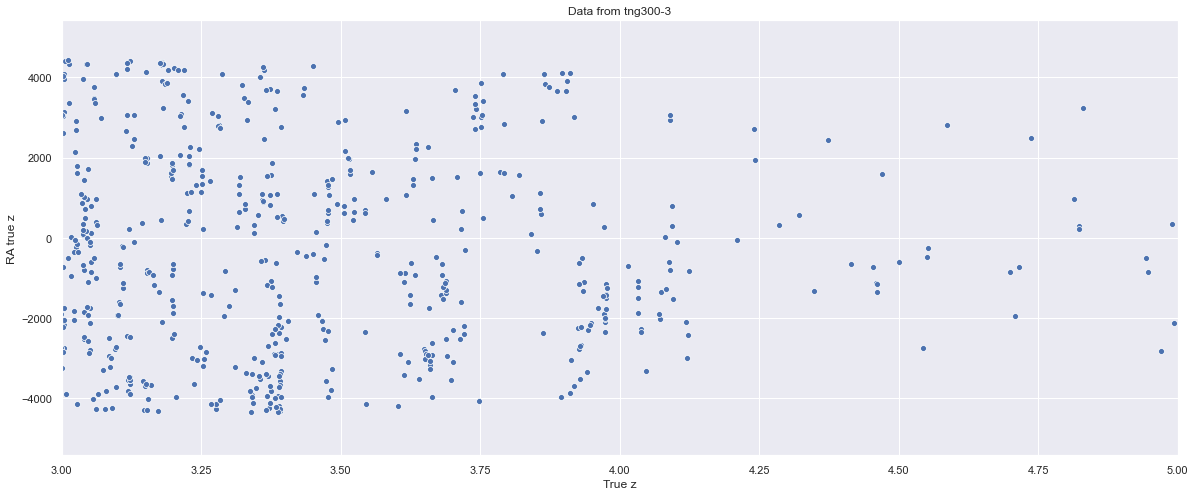

In [81]:
# Examples
ra_vs_redshift('RA true z', 'True z', dash1)
ra_vs_redshift('RA true z', 'True z', dash2) # Weird shape? kinda cone like, which is I suppose what we want
ra_vs_redshift('RA true z', 'True z', dash3)


# Test space for greg

In [ ]:
# Try out diffrent graphs here!

# Old stuff

In [4]:
massive_primaries_im = mstar_tbl['source_sum'] >= (10.0**9.5)
possible_secondaries_im = mstar_tbl['source_sum'] >= (10.0**7.5)
print(np.sum(massive_primaries_im),np.sum(possible_secondaries_im))

NameError: name 'mstar_tbl' is not defined

In [ ]:
#massive_primaries_cat = sam_catalog['mstar'] >= (10.0**9.5)/(10.0**10.0)
#possible_secondaries_cat = sam_catalog['mstar'] >= (10.0**7.5)/(10.0**10.0)
#print(np.sum(massive_primaries_cat),np.sum(possible_secondaries_cat))

In [ ]:
#zi = sam_z[indices] >= 2.0
#print(sam_z[indices].shape,sam_z.shape,mstar_tbl['source_sum'].shape)
#mzi=np.logical_and(massive_primaries_im==True,zi==True)
#print(np.sum(mzi))

In [ ]:
print(sam_catalog.colnames)
print(mstar_tbl.colnames)
print(input_skycoords.shape,sam_z.shape)

In [ ]:
def count_pairs(pri_z,pri_m,pri_sc,sec_z,sec_m,sec_sc,pri_kpcas,d_kpc=50.0,zfrac=0.02,mfrac=0.1):
    #print(pri_z,pri_m)
    sep = pri_sc.separation(sec_sc)
    sep_kpc = pri_kpcas*sep.to('arcsec').value
    slist = np.logical_and(sep_kpc > 1.0, np.logical_and(np.logical_and(sep_kpc < d_kpc,np.abs(sec_z-pri_z)<zfrac*(1.0+pri_z)),sec_m/pri_m >= mfrac))
    num_pairs=np.sum(slist)
    return num_pairs, sep_kpc

In [ ]:
zbins=((1.0,2.0),(2.0,2.5),(2.5,3.0),(3.0,4.0),(4.0,5.0),(5.0,6.0),(6.0,8.0))
zpts =(1.5,2.25,2.75,3.5,4.5,5.5,7.0)
fp_im=[]
fp_cat=[]
for zb in zbins:
    zl=zb[0] ; zr=zb[1]
    this_zi= np.logical_and(sam_z[indices]>=zl,sam_z[indices]<zr)
    this_zi_c = np.logical_and(sam_z>=zl,sam_z<zr)
    
    this_pzi=np.logical_and(massive_primaries_im==True,this_zi==True)
    this_szi=np.logical_and(possible_secondaries_im==True,this_zi==True)
    
    this_pzi_c=np.logical_and(massive_primaries_cat==True,this_zi_c==True)
    this_szi_c=np.logical_and(possible_secondaries_cat==True,this_zi_c==True)
    
    pri_indices = np.where(this_pzi==True)[0]
    sec_indices = np.where(this_szi==True)[0]
    
    pri_indices_c = np.where(this_pzi_c==True)[0]
    sec_indices_c = np.where(this_szi_c==True)[0]
        
    pairs_this_z=0
    pri_this_z=0
    skl=[]
    
    for pi in pri_indices:
        pri_m=mstar_tbl['source_sum'][pi]
        pri_z=sam_z[indices][pi]
        pri_sc=source_skycoords[pi]
        pri_kpcas=sam_catalog['kpc_per_arcsec'][indices][pi]
        sec_m=mstar_tbl['source_sum'][sec_indices]
        sec_z=sam_z[indices][sec_indices]
        sec_sc=source_skycoords[sec_indices]
        npairs,sk = count_pairs(pri_z,pri_m,pri_sc,sec_z,sec_m,sec_sc,pri_kpcas)
        pri_this_z+=1
        pairs_this_z+=npairs
        skl.append(sk)
    #print(np.median(np.asarray(skl)),np.min(np.asarray(skl)))
        
    pairs_this_z_c=0
    pri_this_z_c=0
    for pi in pri_indices_c:
        pri_m=sam_catalog['mstar'][pi]
        pri_z=sam_z[pi]
        pri_sc=input_skycoords[pi]
        pri_kpcas=sam_catalog['kpc_per_arcsec'][pi]
        sec_m=sam_catalog['mstar'][sec_indices_c]
        sec_z=sam_z[sec_indices_c]
        sec_sc=input_skycoords[sec_indices_c]
        npairs,sk = count_pairs(pri_z,pri_m,pri_sc,sec_z,sec_m,sec_sc,pri_kpcas)
        pri_this_z_c+=1
        pairs_this_z_c+=npairs
        skl.append(sk)
    #print(np.median(np.asarray(skl)),np.min(np.asarray(skl)))        

    if len(pri_indices) > 0:
        print(zb,pri_this_z,pairs_this_z,pairs_this_z/pri_this_z, pairs_this_z_c/pri_this_z_c)
        fp_im.append(pairs_this_z/pri_this_z)
        fp_cat.append(pairs_this_z_c/pri_this_z_c)
    else:
        fp_im.append(0.0)
        fp_cat.append(0.0)

In [ ]:
fig, ((ax1)) = plt.subplots(1, 1, figsize=(12, 8),dpi=300)
ax1.plot(zpts,fp_im,marker='o',linestyle='None',markersize=20,markerfacecolor='Black',mec='None')
ax1.plot(zpts,fp_cat,marker='s',linestyle='None',markersize=20,markerfacecolor='Orange',mec='None')
ax1.legend(('Image-Based', 'Catalog-Based'),loc='upper left',fontsize=20)
ax1.set_xlabel('redshift',size=25)
ax1.set_ylabel('Pair Fraction',size=25)
ax1.set_ylim(0.0,1.60)
ax1.tick_params(labelsize=25)
fig.savefig('F356W/SAM_Pairs_Im_vs_Cat_Mass95.png',dpi=300)

In [ ]:
ubins=((20.0,15.0),(15.0,10.0),(10.0,7.0),(7.0,4.0),(4.0,2.0),(2.0,1.0))
upts =(20.0,15.0,10.0,7.0,4.0,2.0)
fp_im=[]
fp_cat=[]
for ub in ubins:
    ul=ub[0] ; ur=ub[1]
    zl=3.0
    zr=10.0
    this_zi= np.logical_and(sam_z[indices]>=zl,sam_z[indices]<zr)
    this_zi_c = np.logical_and(sam_z>=zl,sam_z<zr)
    
    this_pzi=np.logical_and(massive_primaries_im==True,this_zi==True)
    this_szi=np.logical_and(possible_secondaries_im==True,this_zi==True)
    
    this_pzi_c=np.logical_and(massive_primaries_cat==True,this_zi_c==True)
    this_szi_c=np.logical_and(possible_secondaries_cat==True,this_zi_c==True)
    
    pri_indices = np.where(this_pzi==True)[0]
    sec_indices = np.where(this_szi==True)[0]
    
    pri_indices_c = np.where(this_pzi_c==True)[0]
    sec_indices_c = np.where(this_szi_c==True)[0]
        
    pairs_this_z=0
    pri_this_z=0
    skl=[]
    
    for pi in pri_indices:
        pri_m=mstar_tbl['source_sum'][pi]
        pri_z=sam_z[indices][pi]
        pri_sc=source_skycoords[pi]
        pri_kpcas=sam_catalog['kpc_per_arcsec'][indices][pi]
        sec_m=mstar_tbl['source_sum'][sec_indices]
        sec_z=sam_z[indices][sec_indices]
        sec_sc=source_skycoords[sec_indices]
        npairs,sk = count_pairs(pri_z,pri_m,pri_sc,sec_z,sec_m,sec_sc,pri_kpcas,mfrac=1.0/ul)
        pri_this_z+=1
        pairs_this_z+=npairs
        skl.append(sk)
    #print(np.median(np.asarray(skl)),np.min(np.asarray(skl)))
        
    pairs_this_z_c=0
    pri_this_z_c=0
    for pi in pri_indices_c:
        pri_m=sam_catalog['mstar'][pi]
        pri_z=sam_z[pi]
        pri_sc=input_skycoords[pi]
        pri_kpcas=sam_catalog['kpc_per_arcsec'][pi]
        sec_m=sam_catalog['mstar'][sec_indices_c]
        sec_z=sam_z[sec_indices_c]
        sec_sc=input_skycoords[sec_indices_c]
        npairs,sk = count_pairs(pri_z,pri_m,pri_sc,sec_z,sec_m,sec_sc,pri_kpcas,mfrac=1.0/ul)
        pri_this_z_c+=1
        pairs_this_z_c+=npairs
        skl.append(sk)
    #print(np.median(np.asarray(skl)),np.min(np.asarray(skl)))        

    if len(pri_indices) > 0:
        print(zb,pri_this_z,pairs_this_z,pairs_this_z/pri_this_z, pairs_this_z_c/pri_this_z_c)
        fp_im.append(pairs_this_z/pri_this_z)
        fp_cat.append(pairs_this_z_c/pri_this_z_c)
    else:
        fp_im.append(0.0)
        fp_cat.append(0.0)

In [ ]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

fig, ((ax1)) = plt.subplots(1, 1, figsize=(12, 8),dpi=300)
ax1.loglog(upts,fp_im,marker='o',linestyle='None',markersize=20,markerfacecolor='Black',mec='None')
ax1.loglog(upts,fp_cat,marker='s',linestyle='None',markersize=20,markerfacecolor='Orange',mec='None')
ax1.legend(('Image-Based', 'Catalog-Based'),loc='upper left',fontsize=20)
ax1.set_xlabel(r'$M_1/M_2$',size=25)
ax1.set_ylabel('Pair Fraction',size=25)
ax1.set_ylim(0.05,2.0)
ax1.set_xlim(25.0,1.7)
ax1.set_xticks(upts)
ax1.set_xticklabels([20,15,10,7,4,2])
ax1.yaxis.set_major_formatter(FormatStrFormatter('%4.1f'))
ax1.tick_params(labelsize=25)
ax1.tick_params(which='minor',bottom=False)
fig.savefig('F356W/SAM_Ratios_Im_vs_Cat_Mass95_z3_29.png',dpi=300)